
<h1><center><font size="6">MobileNet Architecture Notebook</font></center></h1>



# <a id='0'>Contents</a>
- <a href='#1'>Google Colab Only</a>
    - Mounting Google Drive
    - Confirming Connection to GPU
- <a href='#2'>Importing Packages</a>  
- <a href='#3'>Preprocessing Images</a>
- <a href='#4'>Generating Datasets</a> 
    - Save Entire Dataset
    - Train-Validation-Test Split
- <a href='#5'>Preprocessing Data</a>
- <a href='#6'>Modeling</a>
    - Generating Datasets
    - Constructing and Compiling Model
    - Defining Callbacks
    - Training the Model
    - Saving the Model
    - Evaluating the Model
    - Loading the Model
    - Predicting on Holdout Set
- <a href='#7'>Making Predictions</a>      



# <a id ='1'>Google Colab Only</a>




## Mounting Google Drive (Google Only)

This notebook was run on Google Colab for GPU acceleration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Confirming connection to GPU (Google Only)

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# <a id='2'>Importing Packages</a>

<a href='#0'>Back to Top</a> 

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import ast
import pickle
import time
import glob as glob
import random
import tempfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential, load_model, save_model, Model, model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalCrossentropy, CategoricalAccuracy, TopKCategoricalAccuracy

start = dt.datetime.now()

### VSCODE below

from utils import *

%reload_ext autoreload
%autoreload 2

In [2]:
# Apparently you may use different seed values at each stage
seed_value = 42

# Set `PYTHONHASHSEED` environment variable at fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set `python` built-in pseudo-random generator at fixed value
random.seed(seed_value)

# Set `numpy` pseudo-random generator at fixed value
np.random.seed(seed_value)

# Set `tensorflow` pseudo-random generator at fixed value
tf.random.set_seed(seed_value)

# Configure new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2021-09-24 00:08:52.473651: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# <a id='3'>Preprocessing Images</a>

<a href='#0'>Back to Top</a> 

In [6]:
# Switching between different folders
base_dir = '/content/drive/MyDrive/Colab Notebooks/Flictionary/animals'
# base_dir = '../animals'

In [7]:
startTime = time.time()

In [8]:

classes_path = os.listdir(base_dir + '/train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
# classes_path.pop(0)
classes_path

['ant.csv',
 'bat.csv',
 'bear.csv',
 'bee.csv',
 'butterfly.csv',
 'camel.csv',
 'cat.csv',
 'cow.csv',
 'crab.csv',
 'crocodile.csv',
 'dog.csv',
 'dolphin.csv',
 'dragon.csv',
 'duck.csv',
 'elephant.csv',
 'flamingo.csv',
 'frog.csv',
 'giraffe.csv',
 'hedgehog.csv',
 'horse.csv',
 'kangaroo.csv',
 'lion.csv',
 'lobster.csv',
 'monkey.csv',
 'mosquito.csv',
 'mouse.csv',
 'octopus.csv',
 'owl.csv',
 'panda.csv',
 'parrot.csv',
 'penguin.csv',
 'pig.csv',
 'rabbit.csv',
 'raccoon.csv',
 'rhinoceros.csv',
 'scorpion.csv',
 'sea turtle.csv',
 'shark.csv',
 'sheep.csv',
 'snail.csv',
 'snake.csv',
 'spider.csv',
 'squirrel.csv',
 'swan.csv',
 'tiger.csv',
 'whale.csv',
 'zebra.csv']

In [9]:
class_dict = {x[:-4]:i for i, x in enumerate(classes_path)}
labels = {x[:-4] for i, x in enumerate(classes_path)}
n_labels = len(labels)
print("Number of labels: {}".format(n_labels))

Number of labels: 47


# <a id ='4'>Generating Datasets</a>

<a href='#0'>Back to Top</a> 

In [10]:
path = '/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/'
all_files = glob.glob(path + "/*.csv")

li = []
count = 0

for filename in all_files:
    print(filename)
    df_reduced = pd.read_csv(filename, index_col=None, header=0, nrows=50000)
    df_reduced = df_reduced[df_reduced['recognized']==True].sample(n=10000, random_state=42)
    
    count += 1
    print(df_reduced.size, count ,'/', 47)
    li.append(df_reduced)

frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.sample(n=100000, random_state=42)

del li

/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/ant.csv
60000 1 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bat.csv
60000 2 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bear.csv
60000 3 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/bee.csv
60000 4 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/butterfly.csv
60000 5 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/camel.csv
60000 6 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/cat.csv
60000 7 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/cow.csv
60000 8 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/crab.csv
60000 9 / 47
/content/drive/MyDrive/Colab Notebooks/Flictionary/animals/train_simplified/crocodile.csv
60000 10 / 47
/content/driv

In [12]:
frame['target'] = frame.word.apply(lambda x: class_dict[x])
frame.head()

,countrycode,drawing,key_id,recognized,timestamp,word,target
207110,IN,"[[[40, 32, 15, 0, 47, 46, 49, 58, 78, 61, 88, ...",5124353249247232,True,2017-01-13 18:14:17.090690,kangaroo,20
40471,TH,"[[[123, 134, 149, 157, 156, 150, 142, 123, 102...",4522455181819904,True,2017-01-31 14:48:25.209720,butterfly,4
220536,GB,"[[[170, 174, 175, 172, 168], [10, 24, 38, 40, ...",5134454345433088,True,2017-03-28 19:38:18.374820,lobster,22
239834,HU,"[[[75, 64, 52, 42, 41, 44, 58, 75, 94, 118, 15...",4739146482450432,True,2017-01-28 15:38:58.020630,monkey,23
406539,US,"[[[5, 12, 28, 46, 87, 113, 132, 150, 161, 171,...",4546748368289792,True,2017-03-17 16:40:16.127080,snake,40


## Save Entire Dataset

In [15]:
frame.to_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/mobilenet_frame.csv', index=False)
# frame.to_csv('../data/frame.csv', index=False)

In [9]:
frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/mobilenet_frame.csv')
# frame = pd.read_csv('../data/frame.csv')

In [10]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   countrycode  100000 non-null  object
 1   drawing      100000 non-null  object
 2   key_id       100000 non-null  int64 
 3   recognized   100000 non-null  bool  
 4   timestamp    100000 non-null  object
 5   word         100000 non-null  object
 6   target       100000 non-null  int64 
dtypes: bool(1), int64(2), object(4)
memory usage: 4.7+ MB


## Train-Validation-Test Split

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(frame.drop(['countrycode', 'word', 'key_id', 'target', 'recognized', 'timestamp'], axis=1), 
                                                    frame['target'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    shuffle = True)

In [14]:
len(X_train)

80000

In [15]:
validation = pd.concat([X_valid, y_valid], axis=1)
validation.head()

,drawing,target
377922,"[[[12, 10, 0, 39, 59], [17, 53, 90, 71, 66]], ...",37
231068,"[[[88, 82, 77, 72, 72, 77, 85, 98, 114, 132, 1...",23
273817,"[[[140, 111, 89, 67, 53, 50, 61, 79, 96, 126, ...",27
193563,"[[[15, 29, 34, 52, 64, 81, 121, 127, 133, 133,...",19
310841,"[[[43, 60, 87, 110, 133, 140, 137, 124, 113, 9...",31


In [16]:
X_valid, X_test, y_valid, y_test = train_test_split(validation.drop(['target'], axis=1), 
                                                    validation['target'], 
                                                    test_size = 0.5, 
                                                    random_state = 42,
                                                    shuffle = True)

In [20]:
len(X_valid)

10000

# <a id='5'>Preprocessing Data</a>

<a href='#0'>Back to Top</a> 

In [4]:
size = 96

In [5]:
def draw_cv2(raw_strokes, size=size, lw=6):
    img = np.zeros((256, 256), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != 256:
        return cv2.resize(img, (size, size))
    else:
        return img
        
def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x

In [6]:
le = LabelEncoder()

In [33]:
X_tr = df_to_image_array(X_train, size)
y_tr = le.fit_transform(y_train)
y_tr = to_categorical(y_tr)
print(X_tr.shape, y_tr.shape)

(80000, 96, 96, 1) (80000, 47)


In [34]:
# For saving the pickles
with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_train.pickle', 'wb') as f:
    pickle.dump(X_tr, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_train.pickle', 'wb') as f:
    pickle.dump(y_tr, f, pickle.HIGHEST_PROTOCOL)

In [35]:
del X_tr

In [36]:
X_val = df_to_image_array(X_valid, size)
y_val = le.transform(y_valid)
y_val = to_categorical(y_val)
print(X_val.shape, y_val.shape)

(10000, 96, 96, 1) (10000, 47)


In [37]:
with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_valid.pickle', 'wb') as f:
    pickle.dump(X_val, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_valid.pickle', 'wb') as f:
    pickle.dump(y_val, f, pickle.HIGHEST_PROTOCOL)

In [90]:
X_tt = df_to_image_array(X_test, size)
y_tt = le.transform(y_test)
y_tt = to_categorical(y_tt)
print(X_tt.shape, y_tt.shape)

(10000, 96, 96, 1) (10000, 47)


In [91]:
with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_test.pickle', 'wb') as f:
    pickle.dump(X_tt, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_test.pickle', 'wb') as f:
    pickle.dump(y_tt, f, pickle.HIGHEST_PROTOCOL)

In [20]:
# For loading the pickles

X_tr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_train.pickle', 'rb'))
y_tr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_train.pickle', 'rb'))
X_val = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_valid.pickle', 'rb'))
y_val = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_valid.pickle', 'rb'))
X_tt = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_test.pickle', 'rb'))
y_tt = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_test.pickle', 'rb'))

In [10]:
X_tr = pickle.load(open('../pickle/X_train.pickle', 'rb'))
y_tr = pickle.load(open('../pickle/y_train.pickle', 'rb'))
X_val = pickle.load(open('../pickle/X_valid.pickle', 'rb'))
y_val = pickle.load(open('../pickle/y_valid.pickle', 'rb'))
X_tt = pickle.load(open('../pickle/X_test.pickle', 'rb'))
y_tt = pickle.load(open('../pickle/y_test.pickle', 'rb'))

In [11]:
X_tr.shape

(80000, 96, 96, 1)

# <a id='6'>Modeling</a>

<a href='#0'>Back to Top</a> 

## Generating Datasets

In [12]:
BATCH_SIZE = 32
SIZE = 96
N_CLASSES = 47

In [13]:
# image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip = True)

# rescale pixel values for remaining datasets
datagen = ImageDataGenerator(rescale = 1./255)

# create train dataset with augmentation
train_generator = train_datagen.flow(X_tr, y_tr, 
                                    batch_size=BATCH_SIZE,
                                    seed=42)

# do not include augmentation into validation set
val_generator = datagen.flow(X_val, y_val,
                             batch_size=BATCH_SIZE,
                             seed=42)

# set shuffle to False and batch size to 1 for test dataset
test_generator = datagen.flow(X_tt, y_tt,
                              batch_size=1,
                              seed=42,
                              shuffle=False)                                                               

## Constructing and Compiling the Model

In [14]:
# Hotfix function
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

# Run the function
make_keras_picklable()

In [24]:
model = MobileNet(input_shape = (96, 96, 1), 
                    alpha = 1., 
                    weights = None,
                    classes = 47
)
model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss='categorical_crossentropy',
              metrics=[CategoricalCrossentropy(),
                       CategoricalAccuracy(),
                       TopKCategoricalAccuracy(k=3)
                       ])
print(model.summary())

Model: "mobilenet_1.00_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 48, 48, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 48, 48, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 48, 48, 32)  

## Defining Callbacks

In [26]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.1, 
                                 patience=4,
                                 min_delta=0.005, 
                                 mode='min',  
                                 verbose=1)
filepath = '/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet4/model.{epoch:02d}-{val_loss:.2f}.hdf5'
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet4/log.csv')


## Training the Model

In [27]:
histories = []
history = model.fit_generator(generator = train_generator,
                               validation_data = val_generator,
                               steps_per_epoch = len(train_generator),
                               validation_steps = len(val_generator),
                               epochs = 50,
                               verbose = 1,
                               callbacks = [lr_reduction, mcp_save, csv_logger])
histories.append(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
2500/2500 [==============================] - 110s 36ms/step - loss: 3.6488 - categorical_crossentropy: 3.6488 - categorical_accuracy: 0.0604 - top_k_categorical_accuracy: 0.1588 - val_loss: 3.8541 - val_categorical_crossentropy: 3.8541 - val_categorical_accuracy: 0.0608 - val_top_k_categorical_accuracy: 0.1649

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet4/model.01-3.85.hdf5
Epoch 2/50
2500/2500 [==============================] - 83s 33ms/step - loss: 3.4252 - categorical_crossentropy: 3.4252 - categorical_accuracy: 0.0999 - top_k_categorical_accuracy: 0.2401 - val_loss: 3.3975 - val_categorical_crossentropy: 3.3975 - val_categorical_accuracy: 0.1245 - val_top_k_categorical_accuracy: 0.2743

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet4/model.02-3.40.hdf5
Epoch 3/50
2500/2500 [==============================] - 92s 37ms/step - loss: 3.1802 - categorical_crossentropy: 3.

## Save Model for Flask

In [28]:
# Saving model in whole
model.save('/content/drive/MyDrive/Colab Notebooks/Flictionary/model3/h5/model_h5.h5')

In [29]:
model.save('/content/drive/MyDrive/Colab Notebooks/Flictionary/model3/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Flictionary/model3/model/assets


In [31]:
# Save
with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/model3/model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Evaluating Model

In [32]:
# Create dataframe of the evaluation metrics in each epoch
hist_df = pd.concat([pd.DataFrame(history.history) for history in histories], sort=True)
hist_df

,categorical_accuracy,categorical_crossentropy,loss,lr,top_k_categorical_accuracy,val_categorical_accuracy,val_categorical_crossentropy,val_loss,val_top_k_categorical_accuracy
0,0.060438,3.648824,3.648824,1.000000e-04,0.158762,0.0608,3.854088,3.854088,0.1649
1,0.099887,3.425169,3.425169,1.000000e-04,0.240050,0.1245,3.397474,3.397474,0.2743
2,0.153113,3.180152,3.180152,1.000000e-04,0.330312,0.2212,2.886893,2.886893,0.4322
3,0.223475,2.867444,2.867444,1.000000e-04,0.429437,0.3165,2.477895,2.477895,0.5514
4,0.285663,2.609003,2.609003,1.000000e-04,0.507150,0.3686,2.288944,2.288944,0.5961
5,0.340725,2.386333,2.386333,1.000000e-04,0.570638,0.4130,2.100664,2.100664,0.6548
6,0.383425,2.219794,2.219794,1.000000e-04,0.615138,0.4611,1.912337,1.912337,0.6933
7,0.415700,2.095440,2.095440,1.000000e-04,0.645000,0.5275,1.636586,1.636586,0.7565
8,0.442313,1.986497,1.986497,1.000000e-04,0.673150,0.5333,1.627705,1.627705,0.7602
9,0.465412,1.887981,1.887981,1.000000e-04,0.695813,0.5733,1.468703,1.468703,0.7876


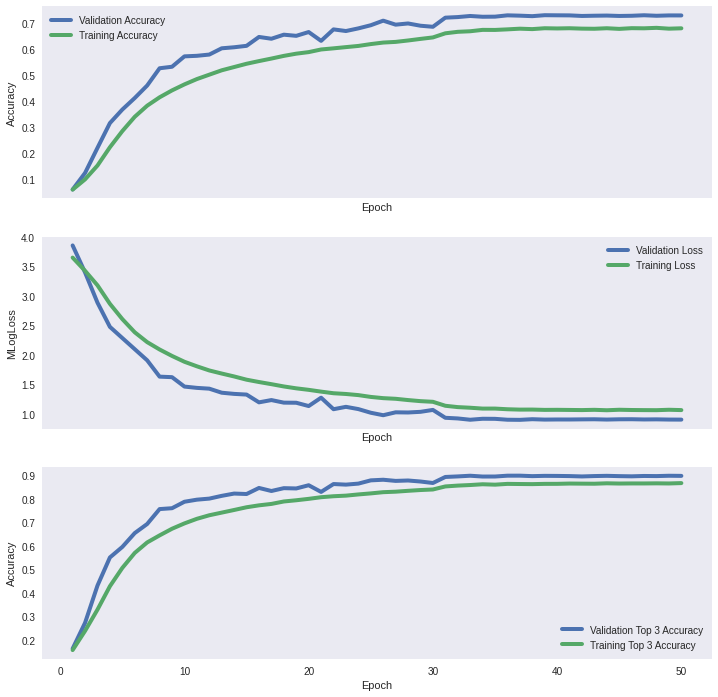

In [34]:

# Create visualizations for training vs. validation metrics
hist_df.index = np.arange(1, len(hist_df)+1)
plt.style.use('seaborn')
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))
axs[0].plot(hist_df.val_categorical_accuracy, lw=4, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=4, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=4, label='Validation Loss')
axs[1].plot(hist_df.loss, lw=4, label='Training Loss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
axs[2].plot(hist_df.val_top_k_categorical_accuracy, lw=4, label='Validation Top 3 Accuracy')
axs[2].plot(hist_df.top_k_categorical_accuracy, lw=4, label='Training Top 3 Accuracy')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].grid()
axs[2].legend(loc=0)
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/history2.png', dpi=300)
plt.show();

## Loading the Model

In [17]:
# tf.keras.backend.clear_session()

# load model in whole
# loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Flictionary/model/h5/model_h5.h5')
loaded_model = load_model('../models/model3/h5/model_h5.h5')

model = load_model('../models/model3/h5/model_h5.h5')

In [16]:
X_tt.shape

(10000, 96, 96, 1)

In [92]:
# test whether the two models produce same results
np.testing.assert_allclose(
    model.predict(X_tt), loaded_model.predict(X_tt)
)

## Predicting on Holdout Set

In [35]:
# get testing accuracy and loss
test_generator.reset()
score = model.evaluate(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Cross Categorical Entropy: " + str(score[1]))
print("Cross Categorical Accuracy: " + str(score[2]))
print("Top 3 Categorical Accuracy: " + str(score[3]))


10000/10000 [==============================] - 48s 5ms/step - loss: 0.8888 - categorical_crossentropy: 0.8888 - categorical_accuracy: 0.7372 - top_k_categorical_accuracy: 0.9002
Loss: 0.8887887001037598
Cross Categorical Entropy: 0.8887887001037598
Cross Categorical Accuracy: 0.7372000217437744
Top 3 Categorical Accuracy: 0.9002000093460083


In [94]:
test_generator.reset()
score_2 = loaded_model.evaluate(test_generator, verbose = 1)

print("Loss: " + str(score_2[0]))
print("Cross Categorical Entropy: " + str(score_2[1]))
print("Cross Categorical Accuracy: " + str(score_2[2]))
print("Top 3 Categorical Accuracy: " + str(score_2[3]))

10000/10000 [==============================] - 47s 5ms/step - loss: 1.5953 - categorical_crossentropy: 1.5953 - categorical_accuracy: 0.6517 - top_k_categorical_accuracy: 0.8449
Loss: 1.5953328609466553
Cross Categorical Entropy: 1.5953328609466553
Cross Categorical Accuracy: 0.6517000198364258
Top 3 Categorical Accuracy: 0.8449000120162964


In [95]:
scores = model.predict(X_tt, verbose=1, batch_size=1)

10000/10000 [==============================] - 36s 4ms/step


In [96]:
scores[0]

array([1.5524889e-11, 4.5797646e-05, 6.0065072e-06, 9.8904884e-09,
       1.4252324e-09, 7.9791035e-11, 1.6698956e-09, 3.9725096e-04,
       4.2287301e-08, 5.5287082e-09, 8.1772050e-08, 1.8081490e-12,
       3.9826358e-05, 3.1887038e-11, 6.1912693e-09, 1.4898968e-10,
       1.1113035e-07, 8.4111974e-08, 2.5373292e-01, 9.2127280e-05,
       1.0050121e-10, 7.3336470e-01, 1.2805695e-07, 8.4000504e-09,
       7.0849344e-09, 2.2544185e-07, 2.3963270e-08, 2.8027540e-07,
       4.8167240e-05, 4.0209688e-08, 2.5799958e-08, 7.7895645e-09,
       7.6356855e-08, 1.0268527e-04, 1.1423578e-08, 2.1060328e-04,
       1.8690451e-10, 3.1921711e-08, 9.0841381e-03, 1.1885507e-12,
       1.7587204e-11, 9.8583515e-14, 2.7406891e-03, 9.1163820e-08,
       1.3227657e-04, 3.0656959e-09, 1.4276396e-06], dtype=float32)

In [97]:
ind = (-scores[0]).argsort()[:3]

In [98]:
ind

array([21, 18, 38])

# <a id='7'>Making Predictions</a>

<a href='#0'>Back to Top</a> 

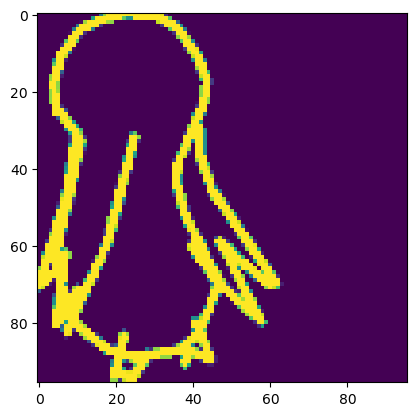

In [19]:
from random import randint
%matplotlib inline
plt.style.use('default')
idx = randint(0, len(X_tt))
img = X_tt[idx]
plt.imshow(img.squeeze())
plt.savefig('sample12.png')

In [82]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, 0)
predictions = model.predict(img_array)[0]
predictions

array([2.8680195e-05, 1.9237683e-03, 3.0692429e-03, 1.4526656e-05,
       1.6372900e-05, 2.3152387e-08, 2.0580545e-07, 1.9131103e-04,
       2.0224691e-06, 6.0585741e-08, 1.4222121e-05, 1.9066622e-08,
       2.2336256e-04, 3.5510158e-08, 9.3761720e-08, 2.1679102e-06,
       8.0396334e-05, 9.5122203e-05, 6.9739860e-01, 7.7092496e-04,
       8.4366029e-06, 6.6620402e-02, 2.0227679e-04, 1.6859301e-05,
       2.6223736e-04, 6.7015062e-06, 5.1484253e-06, 1.7471115e-05,
       2.6967149e-02, 8.1887149e-05, 9.2378315e-05, 5.8481095e-07,
       1.3478427e-05, 1.3494187e-02, 4.8325029e-07, 1.9911374e-03,
       1.3885731e-04, 1.3780542e-07, 1.0034598e-01, 2.9210264e-07,
       4.5813144e-06, 6.0399580e-06, 7.9989366e-02, 2.2933270e-06,
       5.1973308e-03, 2.2465424e-07, 7.0291152e-04], dtype=float32)

In [66]:
ind = (-predictions).argsort()[:10]
ind

array([18, 38, 42, 21, 28, 33, 44,  2, 35,  1])

In [68]:
label_dict = {0:'ant', 1:'bat', 2:'bear', 3:'bee', 4:'butterfly', 
              5:'camel', 6:'cat', 7:'cow', 8:'crab', 9:'crocodile',
              10:'dog', 11:'dolphin', 12:'dragon', 13:'duck', 14:'elephant', 
              15:'flamingo', 16:'frog', 17:'giraffe', 18:'hedgehog', 19:'horse', 
              20:'kangaroo', 21:'lion', 22:'lobster', 23:'monkey', 24:'mosquito', 
              25:'mouse', 26:'octopus', 27:'owl', 28:'panda', 29:'parrot', 
              30:'penguin', 31:'pig', 32:'rabbit', 33:'raccoon', 34:'rhinoceros', 
              35:'scorpion', 36:'sea turtle', 37:'shark', 38:'sheep', 39:'snail', 
              40:'snake', 41:'spider', 42:'squirrel', 43:'swan', 44:'tiger', 
              45:'whale', 46:'zebra'}
top_10_animals = [label_dict[x] for x in ind]
print(top_10_animals)

['hedgehog', 'sheep', 'squirrel', 'lion', 'panda', 'raccoon', 'tiger', 'bear', 'scorpion', 'bat']


In [69]:
predictions.sort()
top_10_values = predictions[::-1][:10]
top_10_values

array([0.6973986 , 0.10034598, 0.07998937, 0.0666204 , 0.02696715,
       0.01349419, 0.00519733, 0.00306924, 0.00199114, 0.00192377],
      dtype=float32)

/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

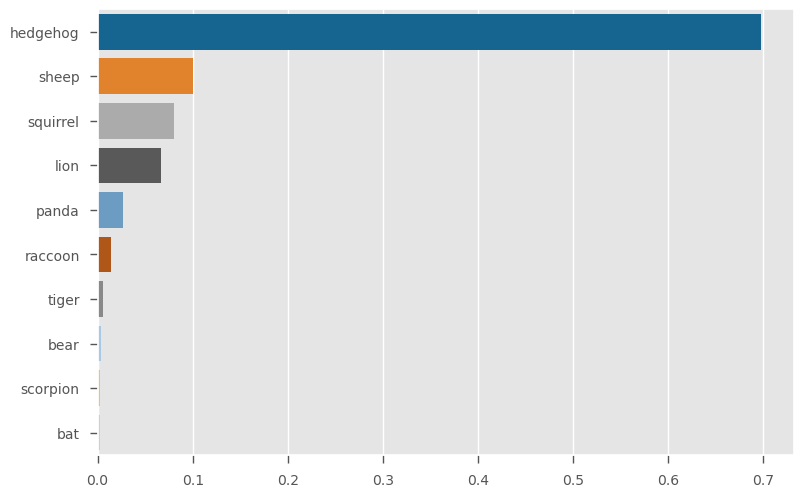

<Figure size 800x550 with 0 Axes>

In [84]:
plt.style.use('tableau-colorblind10')
x = top_10_animals
y = top_10_values
sns.barplot(y, x)
plt.show()
plt.savefig("top10.png")

In [106]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_tt)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_tt, axis=1)
cm = confusion_matrix(y_test.astype(int), y_pred)
print(cm)

[[ 1  1  1 ... 16  0  0]
 [ 0  2  0 ...  5  0  0]
 [ 0  0  0 ...  1  0  0]
 ...
 [ 0  0  0 ... 31  0  2]
 [ 0  0  0 ...  2  0  0]
 [ 0  0  1 ... 32  0  0]]


In [107]:
cm_df = pd.DataFrame(cm,
                     index=['ant',
                            'bat',
                            'bear',
                            'bee',
                            'butterfly',
                            'camel',
                            'cat',
                            'cow',
                            'crab',
                            'crocodile',
                            'dog',
                            'dolphin',
                            'dragon',
                            'duck',
                            'elephant',
                            'flamingo',
                            'frog',
                            'giraffe',
                            'hedgehog',
                            'horse',
                            'kangaroo',
                            'lion',
                            'lobster',
                            'monkey',
                            'mosquito',
                            'mouse',
                            'octopus',
                            'owl',
                            'panda',
                            'parrot',
                            'penguin',
                            'pig',
                            'rabbit',
                            'raccoon',
                            'rhinoceros',
                            'scorpion',
                            'sea turtle',
                            'shark',
                            'sheep',
                            'snail',
                            'snake',
                            'spider',
                            'squirrel',
                            'swan',
                            'tiger',
                            'whale',
                            'zebra'], 
                     columns = ['ant',
                                'bat',
                                'bear',
                                'bee',
                                'butterfly',
                                'camel',
                                'cat',
                                'cow',
                                'crab',
                                'crocodile',
                                'dog',
                                'dolphin',
                                'dragon',
                                'duck',
                                'elephant',
                                'flamingo',
                                'frog',
                                'giraffe',
                                'hedgehog',
                                'horse',
                                'kangaroo',
                                'lion',
                                'lobster',
                                'monkey',
                                'mosquito',
                                'mouse',
                                'octopus',
                                'owl',
                                'panda',
                                'parrot',
                                'penguin',
                                'pig',
                                'rabbit',
                                'raccoon',
                                'rhinoceros',
                                'scorpion',
                                'sea turtle',
                                'shark',
                                'sheep',
                                'snail',
                                'snake',
                                'spider',
                                'squirrel',
                                'swan',
                                'tiger',
                                'whale',
                                'zebra'])

In [ ]:
cm_df

,ant,bat,bear,bee,butterfly,camel,cat,cow,crab,crocodile,dog,dolphin,dragon,duck,elephant,flamingo,frog,giraffe,hedgehog,horse,kangaroo,lion,lobster,monkey,mosquito,mouse,octopus,owl,panda,parrot,penguin,pig,rabbit,raccoon,rhinoceros,scorpion,sea turtle,shark,sheep,snail,snake,spider,squirrel,swan,tiger,whale,zebra
ant,24,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,22,0,0,0,0,23,0,11,0,0,53,0,0,0,25,0,23,0,0
bat,7,23,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,73,0,0,0,0,0,1,0,0,0,13,0,0,0,0,4,0,2,0,0,29,0,0,0,17,0,27,0,0
bear,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,53,0,0,4,0,0,0,0,0,0,107,0,0,0,0,7,0,1,0,0,17,0,0,0,3,0,2,0,0
bee,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,0,0,0,0,0,0,0,0,0,63,0,0,0,0,20,0,0,0,0,8,0,0,0,13,0,1,0,0
butterfly,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,120,0,0,3,0,0,0,0,0,0,70,0,0,0,0,0,0,0,0,0,5,0,0,0,12,0,0,0,0
camel,18,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,19,0,0,0,0,0,1,0,0,0,89,0,0,0,0,7,0,1,0,0,36,0,0,0,24,0,1,0,0
cat,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,0,0,1,0,0,2,0,0,0,89,0,0,0,0,8,0,1,0,0,19,0,0,0,6,0,1,0,0
cow,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,46,0,0,0,0,10,0,2,0,0,111,0,0,0,2,0,7,0,0
crab,12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,0,0,0,0,0,0,0,0,0,50,0,0,0,0,18,0,4,0,0,27,0,0,0,47,0,12,0,0
crocodile,10,3,0,0,0,0,0,0,0,10,0,0,1,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,2,0,0,0,0,28,0,2,0,0,14,0,0,0,2,0,107,0,0


<Figure size 1008x864 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(57.63999999999999, 0.5, 'Actual Values')

Text(0.5, 37.47999999999996, 'Predicted Values')

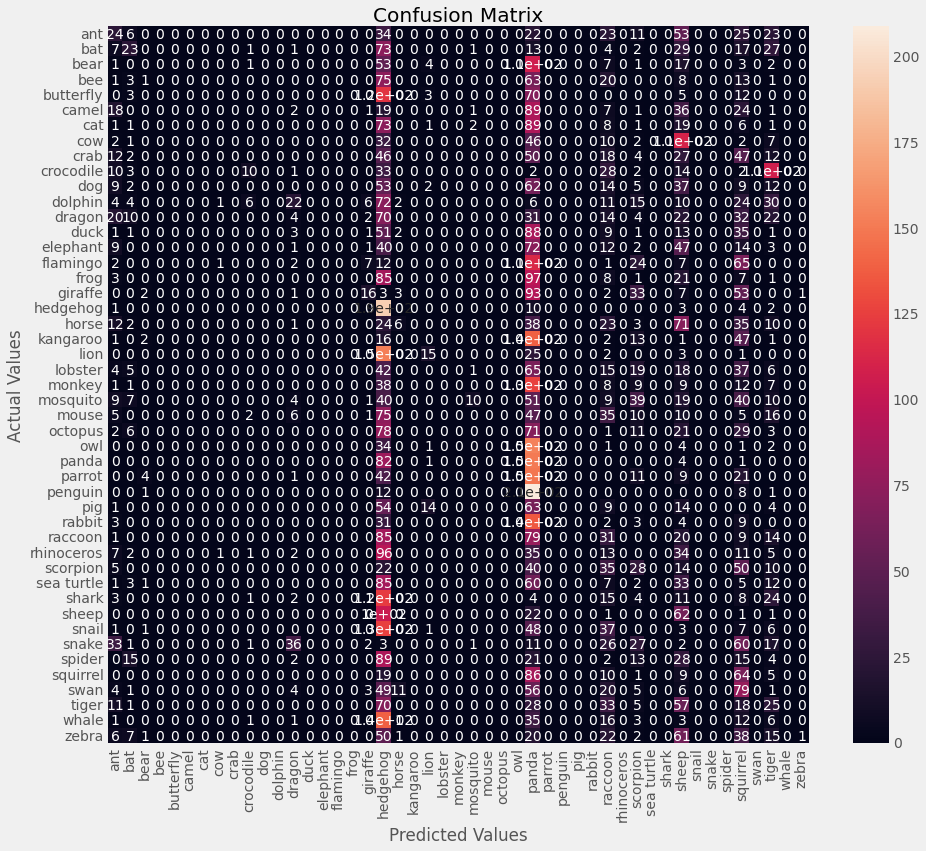

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Figure size 1008x864 with 0 Axes>

([<matplotlib.axis.XTick at 0x7fa831279710>,
 [Text(0, 0, 'flamingo'),
  Text(0, 0, 'bat'),
  Text(0, 0, 'pig'),
  Text(0, 0, 'duck'),
  Text(0, 0, 'owl'),
  Text(0, 0, 'monkey'),
  Text(0, 0, 'dragon'),
  Text(0, 0, 'panda'),
  Text(0, 0, 'butterfly'),
  Text(0, 0, 'lobster'),
  Text(0, 0, 'cow'),
  Text(0, 0, 'rhinoceros'),
  Text(0, 0, 'dolphin'),
  Text(0, 0, 'sheep'),
  Text(0, 0, 'tiger'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'whale'),
  Text(0, 0, 'crab'),
  Text(0, 0, 'snake'),
  Text(0, 0, 'rabbit'),
  Text(0, 0, 'swan'),
  Text(0, 0, 'ant'),
  Text(0, 0, 'crocodile'),
  Text(0, 0, 'zebra'),
  Text(0, 0, 'hedgehog'),
  Text(0, 0, 'dog'),
  Text(0, 0, 'kangaroo'),
  Text(0, 0, 'lion'),
  Text(0, 0, 'giraffe'),
  Text(0, 0, 'elephant'),
  Text(0, 0, 'mouse'),
  Text(0, 0, 'sea turtle'),
  Text(0, 0, 'snail'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'shark'),
  Text(0, 0, 'spider'),
  Text(0, 0, 'raccoon'),
  Text(0, 0, 'scorpion'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'bee'),
  Text(0, 0

([<matplotlib.axis.YTick at 0x7fa831213a50>,
 [Text(0, 0, 'flamingo'),
  Text(0, 0, 'bat'),
  Text(0, 0, 'pig'),
  Text(0, 0, 'duck'),
  Text(0, 0, 'owl'),
  Text(0, 0, 'monkey'),
  Text(0, 0, 'dragon'),
  Text(0, 0, 'panda'),
  Text(0, 0, 'butterfly'),
  Text(0, 0, 'lobster'),
  Text(0, 0, 'cow'),
  Text(0, 0, 'rhinoceros'),
  Text(0, 0, 'dolphin'),
  Text(0, 0, 'sheep'),
  Text(0, 0, 'tiger'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'whale'),
  Text(0, 0, 'crab'),
  Text(0, 0, 'snake'),
  Text(0, 0, 'rabbit'),
  Text(0, 0, 'swan'),
  Text(0, 0, 'ant'),
  Text(0, 0, 'crocodile'),
  Text(0, 0, 'zebra'),
  Text(0, 0, 'hedgehog'),
  Text(0, 0, 'dog'),
  Text(0, 0, 'kangaroo'),
  Text(0, 0, 'lion'),
  Text(0, 0, 'giraffe'),
  Text(0, 0, 'elephant'),
  Text(0, 0, 'mouse'),
  Text(0, 0, 'sea turtle'),
  Text(0, 0, 'snail'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'shark'),
  Text(0, 0, 'spider'),
  Text(0, 0, 'raccoon'),
  Text(0, 0, 'scorpion'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'bee'),
  Text(0, 0

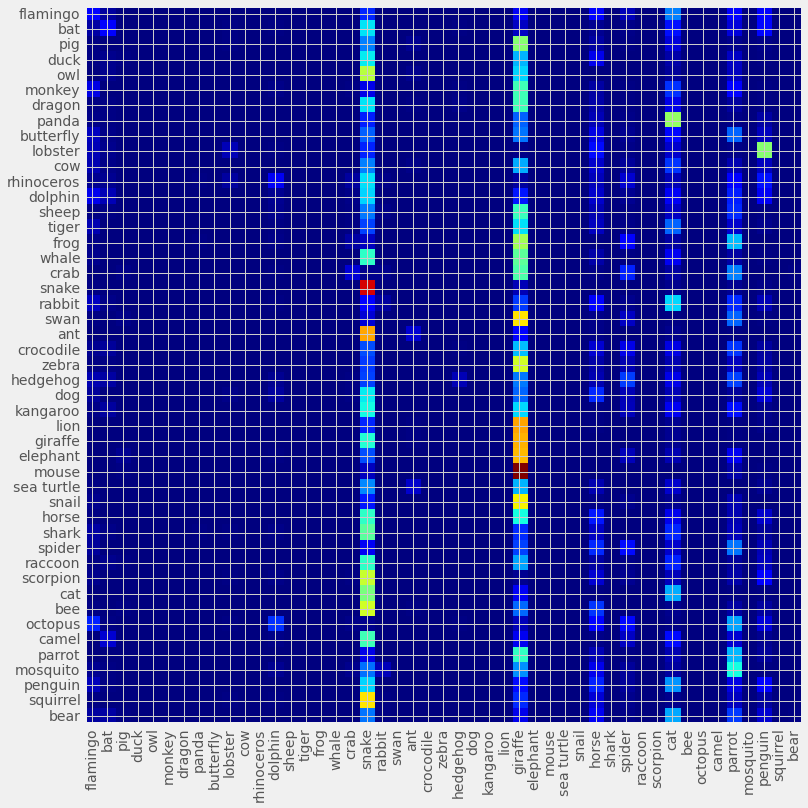

In [ ]:
plt.figure(figsize=(14, 12))
plt.imshow(cm, interpolation='nearest')
plt.xticks(np.arange(0, n_labels), labels, rotation=90)
plt.yticks(np.arange(0, n_labels), labels)

plt.show()

In [ ]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2021-09-16 18:21:44.180294.
Total time 6679s
